<a href="https://colab.research.google.com/github/aditiakhauri/Automobile-Supply-Chain-Management/blob/main/Netflix_Stock_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditiakhauri","key":"b037cdc6eecdd9680b8a3f1ac66b8a42"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                                  title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance                 Student Habits vs Academic Performance               19512  2025-04-12 10:49:08.663000          10545        185  1.0              
zahidmughal2343/global-cancer-patients-2015-2024                     global_cancer_patients_2015_2024                   1261049  2025-04-14 00:05:23.367000           2728         36  1.0              
devdope/200k-spotify-songs-light-dataset                             🎧 200K+ Spotify Songs Light Dataset               17660144  2025-04-16 21:03:24.003000           1540         28  0.9411765    

In [7]:
! kaggle datasets download -d jainilcoder/netflix-stock-price-prediction

Dataset URL: https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction
License(s): CC0-1.0


In [8]:
!unzip -q netflix-stock-price-prediction.zip

In [9]:
!ls

kaggle.json  netflix-stock-price-prediction.zip  NFLX.csv  sample_data


In [11]:
import random
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from pandas_datareader import data
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import FixedFormatter, FixedLocator


In [12]:
path="NFLX.csv"
prices_train=pd.read_csv(path)
cm=sns.light_palette("green",as_cmap=True)
prices_train.head(30).style.background_gradient(cmap=cm)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
5,2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900
6,2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200
7,2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000
8,2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700
9,2018-02-16,278.730011,281.959991,275.690002,278.519989,278.519989,8312400


In [13]:
pd.DataFrame(prices_train.columns, columns=["name"])

,name
0,Date
1,Open
2,High
3,Low
4,Close
5,Adj Close
6,Volume


In [14]:
fig = px.bar(prices_train, x='Date', y='Volume')
fig.update_layout(title=f'Netflix stock price', barmode='stack', font_color="black")
fig.show()

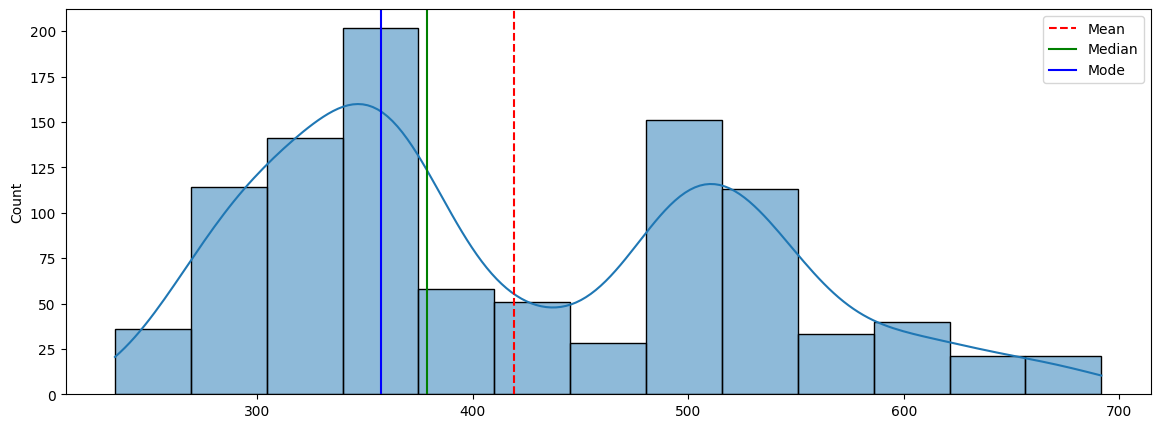

In [15]:
f, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
v_dist_1 = prices_train["Close"].values
sns.histplot(v_dist_1, ax=ax1, kde=True)
mean=prices_train["Close"].mean()
median=prices_train["Close"].median()
mode=prices_train["Close"].mode().values[0]
ax1.axvline(mean, color='r', linestyle='--', label="Mean")
ax1.axvline(median, color='g', linestyle='-', label="Median")
ax1.axvline(mode, color='b', linestyle='-', label="Mode")
ax1.legend()

MONTE CARLO SIMULATION

In [16]:
days_prev_len = 20

prices_train_copy = prices_train["Close"]
print(f"Before: {len(prices_train_copy)}")

prices_train_copy = prices_train_copy[0: len(prices_train_copy) - days_prev_len]
prices_test_copy = prices_train_copy[len(prices_train_copy) - days_prev_len:]
print(f"After: {len(prices_train_copy)}")
print(f"Test dt: {len(prices_test_copy)}")

Before: 1009
After: 989
Test dt: 20


In [17]:
prices_train_copy = np.log(1 + prices_train_copy.pct_change())
prices_train_copy.fillna(0, inplace=True)
prices_train_copy

,Close
0,0.000000
1,0.044086
2,-0.004375
3,-0.056207
4,-0.002522
...,...
984,-0.015891
985,-0.008451
986,-0.010467
987,-0.040794


In [18]:
drift = prices_train_copy.mean() - (0.5 * prices_train_copy.var())
print(f"Drift: {drift}")

Drift: 0.000469582027835995


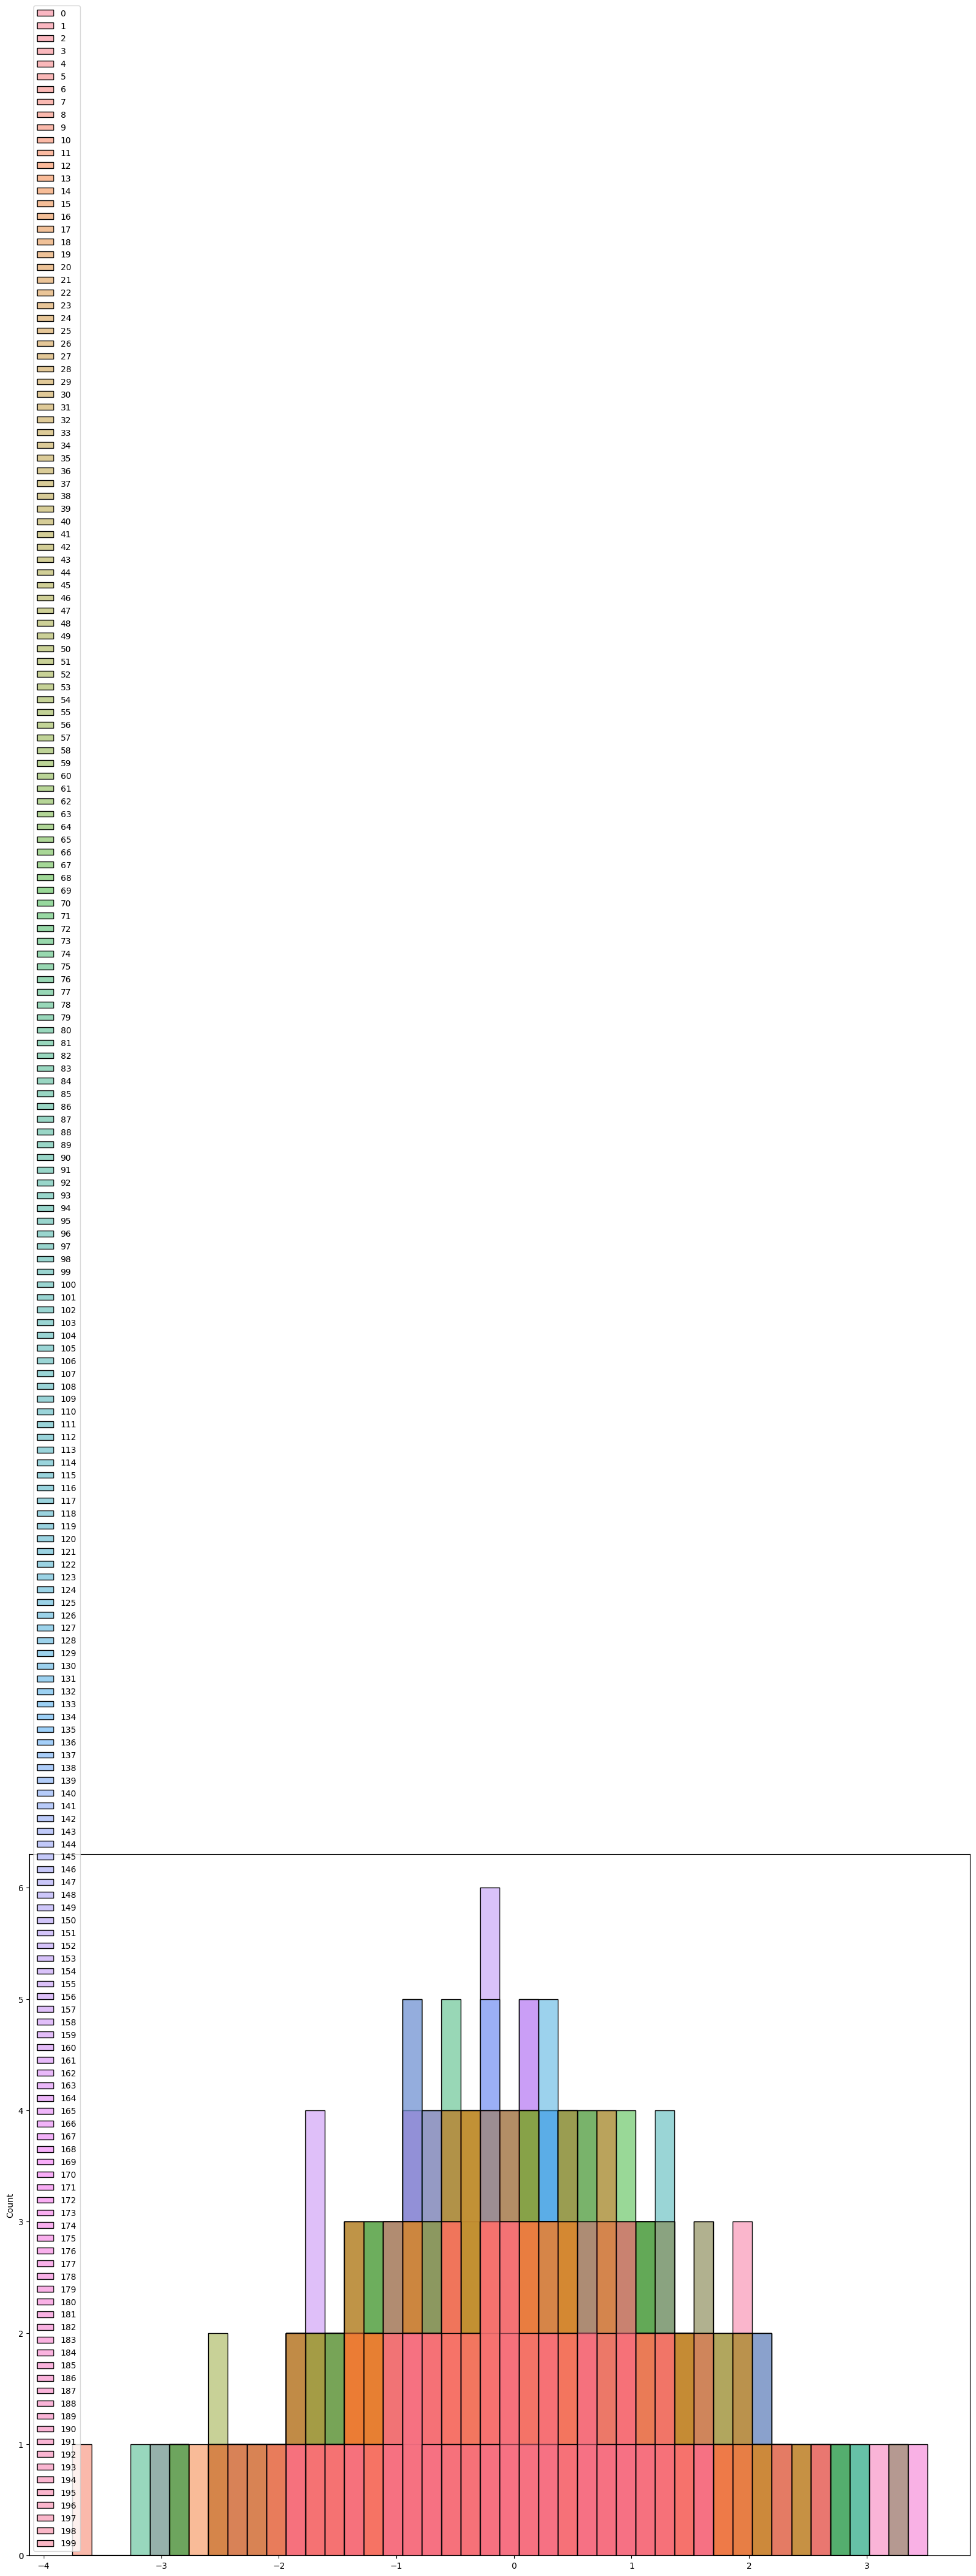

In [19]:
simulations = 200
Z = stats.norm.ppf(np.random.rand(days_prev_len, simulations))

plt.figure(figsize=(20, 15))
sns.histplot(Z)
plt.show()

In [20]:
def get_plot_simulation(predictions: list):
    fig = px.line(title = 'Monte Carlo Simulation')
    for i in range(len(predictions.T)):
        fig.add_scatter(y = predictions.T[i], name = i)
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

df_std = prices_train_copy.std()
days_rt = np.exp(drift + df_std * Z)
days_pred = np.zeros_like(days_rt)
days_pred[0] = prices_train["Close"].iloc[-1]

for i in range(1, days_prev_len):
    days_pred[i] = days_pred[i - 1] * days_rt[i]
get_plot_simulation(days_pred)

In [21]:
s = days_pred.T[0][0:len(prices_test_copy)]

prices_test_copy = prices_test_copy[0:days_prev_len]
mean_absolute_error(prices_test_copy, s)

sqerror = list()
for i in range(len(days_pred.T)):
    sqerror.append(mean_absolute_error(prices_test_copy, days_pred.T[i][0:days_prev_len]))

In [22]:
def plot_best_predict(df: dict, index_max: int, index_min: int):
    fig = px.line(title='Predict Simulation - Monte Carlo', markers=True)
    fig.add_scatter(y=df, name='value')
    fig.add_scatter(y=days_pred.T[index_max], name='biggest pred error')
    fig.add_scatter(y=days_pred.T[index_min], name='smallest pred error')
    fig.update_traces(mode='markers+lines')
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

index_min = np.argmin(sqerror)
index_max = np.argmax(sqerror)
plot_best_predict(prices_test_copy, index_max, index_min)

In [23]:
for index, error in enumerate(sqerror):
    print(f"Simulation: {index} - error: {error}")

Simulation: 0 - error: 167.84266745799988
Simulation: 1 - error: 208.79694253292465
Simulation: 2 - error: 179.96000349110554
Simulation: 3 - error: 198.48565842864735
Simulation: 4 - error: 182.56274998771525
Simulation: 5 - error: 190.75575260954867
Simulation: 6 - error: 186.98696005749161
Simulation: 7 - error: 174.64523515319723
Simulation: 8 - error: 198.2711222598171
Simulation: 9 - error: 203.05037071281066
Simulation: 10 - error: 188.2738869248573
Simulation: 11 - error: 173.85539133970826
Simulation: 12 - error: 207.84119369776317
Simulation: 13 - error: 172.00427630053463
Simulation: 14 - error: 194.29929880107872
Simulation: 15 - error: 222.23912696994898
Simulation: 16 - error: 202.0452763590261
Simulation: 17 - error: 179.09161617101
Simulation: 18 - error: 188.31940111766244
Simulation: 19 - error: 165.65415403646966
Simulation: 20 - error: 188.58491336568133
Simulation: 21 - error: 201.83743291427433
Simulation: 22 - error: 190.91902693654967
Simulation: 23 - error: 145

VOLATILITY CLUSTERING USING GARCH

In [24]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.5 MB/s eta 0:00:00


In [26]:
from arch import arch_model

returns = np.log(1 + prices_train["Close"].pct_change()).dropna()
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [27]:
volatility = garch_fit.conditional_volatility

In [28]:
from arch import arch_model
import numpy as np

returns = np.log(1 + prices_train["Close"].pct_change()).dropna()

model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

num_simulations = 200
forecast_horizon = 20

simulated_paths = []
start_price = prices_train["Close"].iloc[-1]

for _ in range(num_simulations):
    sim = model.simulate(garch_fit.params, nobs=forecast_horizon)
    sim_returns = sim['data']


    prices = [start_price]
    for r in sim_returns:
        prices.append(prices[-1] * np.exp(r))
    simulated_paths.append(prices[1:])



/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [29]:
fig = px.line(title='Monte Carlo Simulation with GARCH Volatility')
for i, path in enumerate(simulated_paths):
    fig.add_scatter(y=path, name=f"Sim {i}", mode='lines')
fig.show()


GARCH VOLATILITY CLUSTERING V/S TRADITIONAL MONTE CARLO

In [30]:
returns = np.log(1 + prices_train["Close"].pct_change()).dropna()
last_close = prices_train["Close"].iloc[-1]
forecast_horizon = 20
num_simulations = 200

Traditional Monte Carlo (Constant Volatility)

In [31]:
mu = returns.mean()
sigma = returns.std()
drift = mu - (0.5 * sigma**2)

Z_const = np.random.normal(size=(forecast_horizon, num_simulations))
returns_const = np.exp(drift + sigma * Z_const)

prices_const = np.zeros_like(returns_const)
prices_const[0] = last_close

for t in range(1, forecast_horizon):
    prices_const[t] = prices_const[t - 1] * returns_const[t]

prices_const = prices_const.T


GARCH-based Monte Carlo

In [32]:
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

prices_garch = []

for _ in range(num_simulations):
    sim = model.simulate(garch_fit.params, nobs=forecast_horizon)
    sim_returns = sim['data']

    path = [last_close]
    for r in sim_returns:
        path.append(path[-1] * np.exp(r))
    prices_garch.append(path[1:])


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [33]:
fig = px.line(title='Comparison: GARCH vs Constant Volatility Monte Carlo')

for i in range(5):
    fig.add_scatter(y=prices_garch[i], name=f'GARCH Sim {i+1}', line=dict(dash='solid'))

for i in range(5):
    fig.add_scatter(y=prices_const[i], name=f'Trad MC Sim {i+1}', line=dict(dash='dot'))

fig.update_layout(paper_bgcolor='white', plot_bgcolor='white', font_color='black')
fig.show()


Error Evaluation

In [34]:
mae_const = [mean_absolute_error(prices_test_copy, path[:forecast_horizon]) for path in prices_const]
mae_garch = [mean_absolute_error(prices_test_copy, path[:forecast_horizon]) for path in prices_garch]

print(f"Average MAE - Traditional Monte Carlo: {np.mean(mae_const):.4f}")
print(f"Average MAE - GARCH Monte Carlo: {np.mean(mae_garch):.4f}")


Average MAE - Traditional Monte Carlo: 186.4372
Average MAE - GARCH Monte Carlo: 183.0557


In [35]:
%whos

Variable              Type                       Data/Info
----------------------------------------------------------
FixedFormatter        type                       <class 'matplotlib.ticker.FixedFormatter'>
FixedLocator          type                       <class 'matplotlib.ticker.FixedLocator'>
MinMaxScaler          type                       <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
Z                     ndarray                    20x200: 4000 elems, type `float64`, 32000 bytes
Z_const               ndarray                    20x200: 4000 elems, type `float64`, 32000 bytes
arch_model            function                   <function arch_model at 0x79847cf305e0>
ax1                   Axes                       Axes(0.125,0.11;0.775x0.77)
cm                    LinearSegmentedColormap    <matplotlib.colors.Linear<...>object at 0x7984911cef50>
data                  module                     <module 'pandas_datareade<...>ndas_datareader/data.py'>
days_pred             nda

EXPORT MODEL USING JOBLIB

In [36]:
df = prices_train.copy()
df["Prev_Close"] = df["Close"].shift(1)
df.dropna(inplace=True)

X = df[["Prev_Close"]]
y = df["Close"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [37]:
import joblib
joblib.dump(model, "netflix_model.joblib")


['netflix_model.joblib']

In [38]:
from google.colab import files
files.download("netflix_model.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>